# Green's function & synthetic seismograms of 1D layered model
_Computational Seismology, Igel (2016)_ <br>
Exercise 2.26

_Write a computer program that uses vertical incidence reflection and transmission coefficients (ignore multiples) to calculate Green’s functions for a 1D model with a few layers. Apply the convolution model to the Green’s function and calculate synthetic seismograms convolving the Green’s function with a source time function (e.g. a Gaussian) according to Eq. 2.48. Discuss the results._


#### Model & assumptions:
<p style="width:45%;float:right;padding-left:25px">
<img src=2.26_layers.png>
<span style="font-size:smaller">
</span>
</p>

- 3 layer model, with the deepest layer (layer 3) being a half-space (no bottom boundary)
- source located in layer 2, receiver located in layer 1
- only considering one reflection per layer; any additional reflections are ignored



Based on these assumptions, there will be four ray paths to consider:
1. source -> receiver 
2. source -> reflected at $b_1$ -> receiver
3. source -> reflected at $b_3$ -> transmitted through $b_2$ -> reciever
4. source -> reflected at $b_3$ -> transmitted through $b_2$ -> reflected at $b_1$ -> receiver

#### Finding the Green's function
The Green's function will comprise a delta function for each ray path. Each term has the form $G(z_{source}, z_{receiver}, t) = A \delta(t - T)$, where $A$ represents the reflection/transmission coefficients and $T$ is the ray's travel time.


$$ \begin{align}
G_1 &= T_{21}               \delta (t - \frac{z_s - z_1}{v_2} - \frac{z_1 - z_r}{v_1}) \\
G_2 &= T_{21} R_{10}        \delta (t - \frac{z_s - z_1}{v_2} - \frac{z_1 + z_r}{v_1}) \\
G_3 &= R_{32} T_{21}        \delta (t - \frac{z_1 + z_2 - z_s}{v_2} - \frac{z_2}{v_2} - \frac{z_1 - z_r}{v_1}) \\
G_4 &= R_{32} T_{21} R_{10} \delta (t - \frac{z_1 + z_2 - z_s}{v_2} - \frac{z_2}{v_2} - \frac{z_1}{v_1} - \frac{z_r}{v_1}) \\
\end{align} $$

Then we sum them all up: $$G = G_1 + G_2 + G_3 + G_4$$


#### Computing seismograms
Next we need to define a source time function $s(t)$. We'll use a Gaussian as suggested, in the form $$-A(t-t_0)e^{-((t-t_0)/b)^2},$$ then finally convolve $G$ with it to produce the seismogram. 

<p style="width:25%; float:right; >
<img src=lambs_setup.png>
<span style="font-size:smaller">
</span>
</p>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Initialize parameters

In [2]:
# simulation parameters
dt = .01                           # time step
t = np.arange(0, 50, dt)           # time array
r = np.linspace(-10, 10, len(t))   # distance from source
n_step = len(t)                    # number of steps

# physical parameters
R10 = 3      # reflection & transmission coefficients
T21 = 2
R32 = 4

zs = 55      # source depth
zr = .5      # receiver depth
h1 = 30      # layer 1 height
h2 = 35      # layer 2 height

v1 = 4       # layer 1 velocity
v2 = 6       # layer 2 velocity

# source time function parameters (see intro)
A = 1
b = .5
t0 = None   # leave this alone to get a randomized t0 based on A and b

In [3]:
# travel times for each ray path
T1 = (zs - h1)/v2 + (h1 - zr)/v1
T2 = (zs - h1)/v2 + (h1 + zr)/v1
T3 = (h1 + h2 + zs)/v2 + h2/v2 + (h1 - zr)/v1
T4 = (h1 + h2 + zs)/v2 + h2/v2 + h1/v1 + zr/v1

# looping prep
trav_times = [T1, T2, T3, T4]
n_raypaths = len(trav_times)
coefs_1 = T21
coefs_2 = T21*R10
coefs_3 = R32*T21
coefs_4 = R32*T21*R10
coefs = [coefs_1, coefs_2, coefs_3, coefs_4]

#### Initialize source time function
For some reason I decided to randomize the choice of t0. I did keep a buffer of 2b around t=0 and the time the first signal is received (so that the impulses don't get cut off).

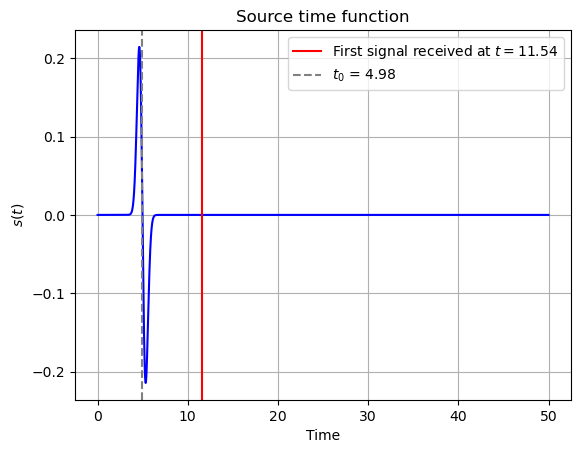

In [4]:
# get random t0 within the interval [2b, tau-2b) where tau is the first signal arrival at receiver
if t0 == None:
    scale = min(trav_times) - 4*b
    np.random.seed(1)
    t0 = scale*np.random.rand(1)[0] + 2*b

# get source time function
def gaussian(t, t0, b,  A=1):
    
    if (t0 + 2*b > min(trav_times)) | (t0 - 2*b <= 0):
        print('Error: This impulse will occur before t=0 and/or after the signal is received! Choose a smaller b or larger t0.')
        return
        
    return -A*(t-t0)*np.exp(-((t - t0)/b)**2)

stf = gaussian(t, t0, b, A)

plt.plot(t, stf, 'b')
plt.axvline(min(trav_times), color = 'red', label = 'First signal received at $t = {:.2f}$'.format(min(trav_times)))
plt.axvline(t0, color = 'gray', linestyle = '--', label = '$t_0$ = {:.2f}'.format(t0))
plt.title('Source time function')
plt.xlabel('Time')
plt.ylabel('$s(t)$')
plt.legend()
plt.grid()

#### Get $G_i$
The number of terms in G will be equal to the number of raypaths.

In [5]:
# initialize array G with shape (# ray paths, # time steps)
G_terms = np.zeros((n_raypaths, n_step))

In [6]:
# calculate each G
for i in range(n_raypaths):
    for j in range(len(t)):
        if t[j] >= trav_times[i]:
            G_terms[i][j] = coefs[i]
        else:
            G_terms[i][j] = 0

# combine the Gs
G = np.sum(G_terms, axis = 0)

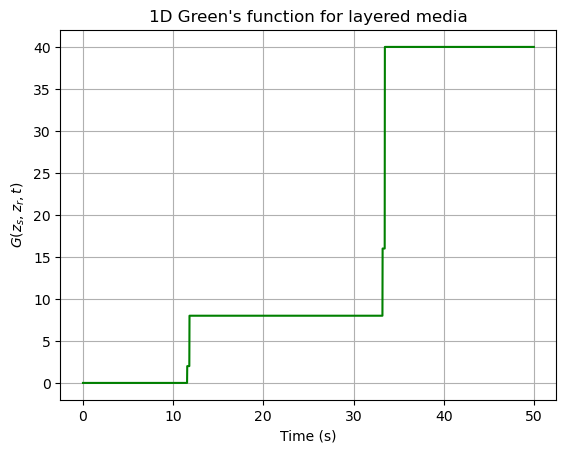

In [7]:
# plot Green's function
fig1 = plt.figure()
plt.plot(t, G, 'g')     
plt.xlabel('Time (s)')
plt.ylabel('$G(z_s, z_r, t)$')
plt.title('1D Green\'s function for layered media')
plt.grid()

#### Compute convolution

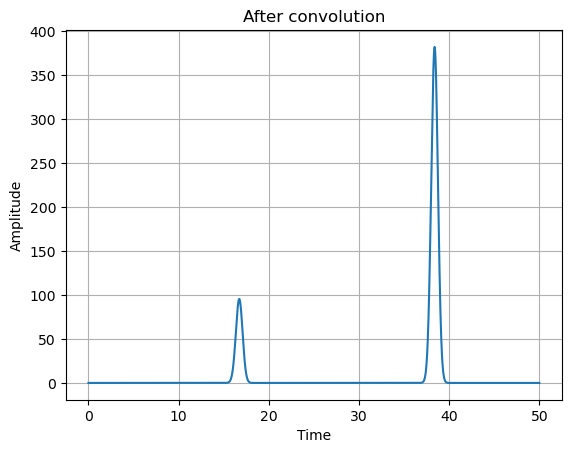

In [8]:
seis = np.convolve(G, stf)[:n_step]
plt.plot(t, seis)
plt.title('After convolution')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid()

Results: Because some of the arrival times are so close together, it looks like some of the signals overlapped and thus got combined in the seismogram. Because we have two main "shelfs" in the Green's function, it checks out that we'd have two peaks after convolution.